<a href="https://colab.research.google.com/github/lucasmartinso/IC/blob/main/C%2B%2B_Pennes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulações numéricas 3D em GPUs de hipertermia com nanopartículas por um modelo de bioaquecimento não linear**

Nome: Lucas Martins Oliveira

Equação a ser modelada:

\begin{equation*}
  \begin{cases}
    \displaystyle \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m + Q_r = \rho c \frac{\partial T}{\partial t} \text{ para } \Omega\\\\
    \displaystyle k \nabla T \cdot\vec{n} = 0 \text{ para } \partial \Omega_{N_{B,C,D}}\\\\
    \displaystyle T  = 37 \text{ para } \partial \Omega_{D_A}\\\\
    \displaystyle T(.,0) = 37
  \end{cases}
\end{equation*}

\begin{equation*}
  \text { onde } T : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o campo de temperatura do tecido } \\
  p,c : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa densidade  e o calor específico  do tecido, respectivamente } \\
  p_b, c_b : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa densidade e o calor específico do sangue, respectivamente } \\
  k : \Omega \times  I \rightarrow \mathbb{R^+} \text { na qual a condutividade térmica é considerada isotrópica, mas não homogênea } \\
  w_b:  \Omega \times {R^+} \times  I \rightarrow \mathbb{R^+} \text { taxa de perfusão sanguínea } \\
  T_a \text {: temperatura arterial } \\
  Q_m : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa a geração de calor metabólico } \\
  f : \Omega \times  I \rightarrow \mathbb{R^+} \text { temperatura prescrita(Dirichelet) ou fluxo (Neumann ou Robin)} \\
  \alpha , \beta : \Omega \times  I \rightarrow \mathbb{R^+} \text { sendo o vetor normal unitário } \\
  Q_r : \Omega \times  I \rightarrow \mathbb{R^+} \text { é o calor externo gerado pelas nanopartículas } \\
\end{equation*}

Inicialmente definimos o dominio, em questão

In [ ]:
%%writefile dominio.h

#ifndef DOMINIO_H
#define DOMINIO_H

class Dominio {
  private:
    int tamX, tamY, tamT;
    float h;
    float ht;
    float *x;
    float *y;
    float *t;

  public:
    Dominio(float passo, int tamx, int tamy, float tempo, int tamt);
    ~Dominio();
    void setX();
    void setY();
    void setT();
    float getX(int indice);
    float getY(int indice);
    float getT(int indice);
};

#endif //DOMINIO_H

Writing dominio.h


In [ ]:
%%writefile dominio.cpp

#include <iostream>
using namespace std;

#include "dominio.h"

Dominio::Dominio(float passo, int tamx, int tamy, float tempo, int tamt) {
  h = passo;
  ht = tempo;
  tamX = tamx;
  tamY = tamy;
  tamT = tamt;
  x = new float[tamX];
  y = new float[tamY];
  t = new float[tamT];
}

Dominio::~Dominio() {
  delete [] x;
  delete [] y;
}

void Dominio::setX() {
  for(int i=0; i<tamX; i++) {
      x[i] = i*h;
  }
}

void Dominio::setY() {
  for(int i=0; i<tamY; i++) {
      y[i] = i*h;
  }
}

void Dominio::setT() {
  for(int i=0; i>tamT; i++) {
    t[i] = i*ht;
  }
}

float Dominio::getX(int indice) {
  if(indice < tamX)
  {
    return x[indice];
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

float Dominio::getY(int indice) {
  if(indice < tamY)
  {
    return y[indice];
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

float Dominio::getT(int indice) {
  if(indice < tamY)
  {
    return t[indice];
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

Writing dominio.cpp


Assim modelamos agora as regiões do nosso espaço em questão que é divida em 4:


---



0.   Derme
1.   Gordura
2.   Músculo
3.   Tumor



---





In [ ]:
%%writefile tecidos.h

#ifndef TECIDOS_H
#define TECIDOS_H

class Tecidos {
  private:
    int *tecidosHumanos;
    int tamX;
    int tamY;
    int detInd(int i, int j);

  public:
    Tecidos(int tamx, int tamy);
    ~Tecidos();
    void set();
    int busca(int i, int j);
    void salvaMatriz();
};

#endif //TECIDOS_H

Writing tecidos.h


In [ ]:
%%writefile tecidos.cpp

#include <iostream>
using namespace std;

#include <fstream>
#include <vector>

#include "tecidos.h"

Tecidos::Tecidos(int tamx, int tamy) {
  tamX = tamx;
  tamY = tamy;
  tecidosHumanos = new int[tamX*tamY];
}

Tecidos::~Tecidos() {
  delete [] tecidosHumanos;
}

int Tecidos::detInd(int i, int j) {
  if(i<tamX && j<tamY)
  {
    return tamY*i + j;
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

void Tecidos::set() {
  for(int i=0; i<tamX; i++) {
     for(int j=0; j<tamY; j++) {
        if((i>(19) && i<(45) && j>(37) && j<(63)))
        {
          //tumor esfera de raio 13mm -> consideramos um quadrado nessa abordagem
          //centro (20,50)mm
          tecidosHumanos[detInd(i,j)] = 3;
        }
        else if(i<2)
        {
          //derme 2mm
          tecidosHumanos[detInd(i,j)] = 0;
        }
        else if(i<12)
        {
          //adiposo
          tecidosHumanos[detInd(i,j)] = 1;
        }
        else
        {
          //musculo
          tecidosHumanos[detInd(i,j)] = 2;
        }
     }
  }
}

int Tecidos::busca(int i, int j) {
  if(i < tamX && j < tamY)
  {
    return tecidosHumanos[detInd(i,j)];
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

void Tecidos::salvaMatriz() {
    // Matriz que vai receber os valores dos tecidos
    vector<vector<int>> matriz;

    // Inicializar a matriz que vai ser salva com elementos
    matriz.resize(tamX);
    for (int i = 0; i < tamX; i++) {
      matriz[i].resize(tamY);
      for (int j = 0; j < tamY; j++) {
        matriz[i][j] =  busca(i,j);
      }
    }

    // Salvar a matriz de tecidos em um arquivo para ser importada posteriormente
    ofstream arquivo("matriz.txt");
    if (arquivo.is_open()) {
      for (const auto& linha : matriz) {
        for (const auto& elemento : linha) {
          arquivo << elemento << " ";
        }
        arquivo << "\n";
      }
      arquivo.close();
      cout << "C++: Matriz de tecidos salva em matriz.txt" << endl;
    } else {
      cerr << "C++: Erro ao abrir o arquivo" << endl;
    }
}

Writing tecidos.cpp


A geração de calor metabólico varia de acordo com a região tratada, temos assim então:

\begin{equation*}
  Q_{m_{muscle}} = Q_{m_{fat}} = Q_{m_{dermis}} = 420.0 \\
  Q_{m_{tumor}} = 4200.0
\end{equation*}

Temos que a condutividade térmica varia de acordo com o tecido, assim obtemos a seguintes relações:

\begin{equation*}
  k_{dermis} = 0.40\\
  k_{fat} = 0.21\\
  k_{muscle} = 0.45\\
  k_{tumor} = 0.55\\
\end{equation*}

A densidade dos tecidos são diferentes uma das outras, dessa forma definimos para a mesma a seguinte variação:

\begin{equation*}
  \rho_{dermis} = 1200\\
  \rho_{fat} = 1000\\
  \rho_{muscle} = 1000\\
  \rho_{tumor} = 1000\\
\end{equation*}

O calor específico dos tecidos são diferentes um dos outros, dessa forma definimos para a mesma a seguinte variação:

\begin{equation*}
  c_{dermis} = 3600\\
  c_{fat} = 2500\\
  c_{muscle} = 3800\\
  c_{tumor} = 4200\\
\end{equation*}

A taxa de perfusão sanguínea varia de acordo com o tecido e com a temperatura que esse se encontra, dessa forma temos que:

\begin{equation*}
  W_{dermis} = 0.5 \\
  W_{fat} =
    \begin{cases}
      \displaystyle 0.36 + 0.36exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      0.72 \text { para } T>45.0
    \end{cases} \\
  W_{muscle} =
    \begin{cases}
      \displaystyle 0.45 + 3.55exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      4.0 \text { para } T>45.0
    \end{cases} \\
    W_{tumor} =
    \begin{cases}
      \displaystyle 0.833 -\frac{(T-37.0)^{4.8}}{5.438E+3} \text { para } 37.0 \leq T \leq 42.0 \\\\
      0.416 \text { para } T>42.0
    \end{cases} \\
\end{equation*}

In [ ]:
%%writefile variaveis.h

#ifndef VARIAVEIS_H
#define VARIAVEIS_H

class Variaveis {
  private:
   float *qm;
   float *k;
   float *w;
   float *p;
   float *c;

  public:
    Variaveis();
    ~Variaveis();
    void setQm();
    void setK();
    void setP();
    void setC();
    void setW();
    float getQm(int tecido);
    float* getK();
    float getP(int tecido);
    float getC(int tecido);
    float getW(int tecido, float temp);
};

#endif //VARIAVEIS_H

Writing variaveis.h


In [ ]:
%%writefile variaveis.cpp

#include <iostream>
#include <cmath>
using namespace std;

#include "variaveis.h"

Variaveis::Variaveis() {
  qm = new float[4];
  k = new float[4];
  w = new float[4];
  p = new float[4];
  c = new float[4];
}

Variaveis::~Variaveis() {
  delete [] qm;
  delete [] k;
  delete [] w;
  delete [] p;
  delete [] c;
}

void Variaveis::setQm() {
  for(int i=0; i<4; i++) {
    i==3 ? qm[i]=4200 : qm[i]=420;
  }
}

void Variaveis::setK() {
  k[0] = 0.4;
  k[1] = 0.21;
  k[2] = 0.45;
  k[3] = 0.55;
}

void Variaveis::setP() {
  for(int i=0; i<4; i++) {
    i==0 ? p[i]=1200 : p[i]=1000;
  }
}

void Variaveis::setC() {
  c[0] = 3600;
  c[1] = 2500;
  c[2] = 3800;
  c[3] = 4200;
}

void Variaveis::setW() {
  w[0] = 0.5;
  w[1] = 4.0;
  w[2] = 0.72;
  w[3] = 0.416;
}

float Variaveis::getQm(int tecido) {
  if(tecido <= 3 && tecido >=0)
    return qm[tecido];
  else {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

float* Variaveis::getK() {
  return k;
}

float Variaveis::getP(int tecido) {
  if(tecido <= 3 && tecido >=0)
    return p[tecido];
  else {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

float Variaveis::getC(int tecido) {
  if(tecido <= 3 && tecido >=0)
    return c[tecido];
  else {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

float Variaveis::getW(int tecido, float temp) {
  if(tecido == 0)
    return w[0];
  else if(tecido == 1)
    return temp > 45.0 ? w[1] : ( 0.36 + 0.36*exp(-pow(temp - 45, 2)/12));
  else if(tecido == 2)
    return temp > 45.0 ? w[2] : ( 0.45 + 3.55*exp(-pow(temp - 45, 2)/12));
  else if(tecido == 3)
    return temp > 42.0 ? w[3] : ( 0.833 - (pow(temp-37, 4.8)/5438));
  else {
    cout << "INDICE INVÁLIDO" << endl;
    exit(1);
  }
}

Writing variaveis.cpp


Temos que o calor gerado pelas nanopartículas vai ser definido pela seguinte expressão:

\begin{equation*}
  Q_r = \sum_{i=1}^{n} A_{i} 𝐞^{-r^2_{i,j}/{r^2_0}}
\end{equation*}

\begin{equation*}
  \text{ r é a distância do local da injeção}\\
  r_0 \text{ é a distância  percorrida pelo calor gerado pelas nanopartículas } \\
  A \text{ é a força máxima da taxa volumétrica de geração de calor } \\
  n \text{ é o número total de pontos de injeção (locais) }
\end{equation*}

No qual, no artigo são considerados três pontos de injeções, nesses 3 pontos a força volumetrica considerada(A) e a distância percorrida pela injeção foi(r0), foram de:

Considerando as respectivas posições de aplicação:

\begin{equation*}
  \text { Posição: } \\
  1: (0.020, 0.055, 0.055) \\
  2: (0.025, 0.045, 0.045) \\
  3: (0.015, 0.040, 0.040) \\
\end{equation*}

\begin{equation*}
  A_1 = 0,8 \times 10^6 W/m^3 \\
  A_2 = 0,7 \times 10^6 W/m^3 \\
  A_3 = 0,7 \times 10^6 W/m^3 \\
\end{equation*}

\begin{equation*}
  r_{0} = 3,1 \times 10^{-3} W/m^3 \\
\end{equation*}


In [ ]:
%%writefile injecoes.h

#ifndef INJECOES_H
#define INJECOES_H

class Injecoes {
  private:
   int tamX;
   int tamY;
   int num_inj;
   float *qr;
   float *r;
   int *posX;
   int *posY;
   float *A;
   float r0;
   int detInd2D(int i, int j);
   int detInd3D(int i, int j, int k);

  public:
    Injecoes(int tamx, int tamy, int num, float dist);
    void setPos();
    void setA();
    void setR(float h);
    void setQr();
    float getQr(int i, int j);
};

#endif //INJECOES_H

Writing injecoes.h


In [ ]:
%%writefile injecoes.cpp

#include <iostream>
#include <cmath>
using namespace std;
#include <fstream>
#include <vector>

#include "injecoes.h"

Injecoes::Injecoes(int tamx, int tamy, int num, float dist) {
  tamX = tamx;
  tamY = tamy;
  num_inj = num;
  r0 = dist;

  qr = new float[tamX*tamY];
  A = new float[num_inj];
  posX = new int[num_inj];
  posY = new int[num_inj];
  r = new float[tamX*tamY*num_inj];
}

int Injecoes::detInd2D(int i, int j) {
  if(i<tamX && j<tamY)
  {
    return tamY*i + j;
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

int Injecoes::detInd3D(int i, int j, int k) {
  if(i<tamX && j<tamY && k<num_inj)
  {
    return i*(tamY*num_inj) + j*(num_inj) + k;
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

void Injecoes::setPos() {
  //injecao 1 -> (20,55)
  posX[0] = 20;
  posY[0] = 55;

  //injecao 2 -> (25,45)
  posX[1] = 25;
  posY[1] = 45;

  //injecao 3 -> (15,40)
  posX[2] = 15;
  posY[2] = 40;
}

void Injecoes::setA() {
  A[0] = 0.8 * pow(10,6);
  A[1] = 0.7 * pow(10,6);
  A[2] = 0.7 * pow(10,6);
}

void Injecoes::setR(float h) {
  for(int i=0; i<tamX; i++) {
    for(int j=0; j<tamY; j++) {
      for(int k=0; k<num_inj; k++) {
        float distancia = sqrt(pow(posX[k]*h -i*h, 2) + pow(posY[k]*h -j*h, 2));

        r[detInd3D(i,j,k)] = distancia;
      }
    }
  }
}

void Injecoes::setQr() {
  for(int i=0; i<tamX; i++) {
    for(int j=0; j<tamY; j++) {
      qr[detInd2D(i,j)] = 0;
      for(int k=0; k<num_inj; k++) {
        qr[detInd2D(i,j)] += A[k]*exp(-pow(r[detInd3D(i,j,k)],2)/pow(r0,2));
      }
    }
  }
}

float Injecoes::getQr(int i, int j) {
  if(i<tamX && j<tamY)
  {
    return qr[detInd2D(i,j)];
  }
  else
  {
    cout << "INDICE DO QR INVALIDO" << endl;
    exit(1);
  }
}

Writing injecoes.cpp


Assim temos que a condutividade térmica, pode ser calculada usando o método do ponto do médio, então:
\begin{equation*}
  k_{i+\frac{1}{2},j} \approx \frac{2k_{i,j}k_{i+1,j}}{k_{i,j}+k_{i+1,j}}
\end{equation*}

Dado que temos o seguinte problema:

\begin{equation*}
  \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m + Q_r = \rho c \frac{\partial T}{\partial t} \\
\end{equation*}

Reorganizando a:

\begin{equation*}
  \frac{ \frac{\partial k  T}{\partial^2t } + w_b c_b(T_a - T) + Q_m + Q_r}{\rho c} =  \frac{\partial T}{\partial t} \\
\end{equation*}

Temos que:

\begin{equation*}
  \frac{\partial{T}}{\partial{t}} \approx \frac{T^{n+1}_{i,j} - T^n_{i,j}}{h_t} \\
  \nabla \cdot k \nabla T \approx \frac{-k_{i+ \frac{1}{2},j}(T_{i,j} - T_{i+1,j}) + k_{i- \frac{1}{2},j}(T_{i-1,j} - T_{i,j}) - k_{i,j+ \frac{1}{2}}(T_{i,j} - T_{i,j+1}) + k_{i,j- \frac{1}{2}}(T_{i,j-1} - T_{i,j})}{h^2} \\
\end{equation*}

Organizando e aglutinando a expressão, temos:

\begin{equation*}
  T^{n+1}_{i,j} = T^n_{i,j} + \frac{r}{h^2}(-T^n_{i,j}(k_{i+ \frac{1}{2},j} + k_{i- \frac{1}{2},j} + k_{i,j+ \frac{1}{2}} + k_{i,j- \frac{1}{2}}) + k_{i+ \frac{1}{2},j}T^n_{i+1,j} + k_{i- \frac{1}{2},j}T^n_{i-1,j} + k_{i,j+ \frac{1}{2}}T^n_{i,j+1} + k_{i,j- \frac{1}{2}}T^n_{i,j-1}) -r c_b w_{b_{i,j}}(T_a -T^n_{i,j}) + r(q_{r_{i,j}} + q_{m_{i,j}}) \\
\end{equation*}

Onde r é:

\begin{equation*}
  r = \frac{h_t}{pc}
\end{equation*}

In [ ]:
%%writefile euler.h

#ifndef EULER_H
#define EULER_H

#include <string>

#include "tecidos.h"
#include "variaveis.h"
#include "injecoes.h"

class Euler {
  private:
    float *sol; //vetor solucao
    float *u; //passo anterior ao da solucao (necessario para resolver o problema)
    int tamX;
    int tamY;
    int tamT;
    int detInd(int i, int j);

  public:
    Euler(int tamx, int tamy, int tamt);
    ~Euler();
    void setU(int ci);
    void resolucao(float cb, float Ta, Tecidos *t, Variaveis *var, float h, float ht, Injecoes *inj);
    void salvaMatriz(float *mat, int i);
};

#endif //EULER_H

Writing euler.h


In [85]:
%%writefile euler.cpp

#include <iostream>
#include <cmath>
using namespace std;
#include <string>
#include <fstream>
#include <vector>
#include <sstream> // Para converter valores numéricos em strings

#include "euler.h"
#include "tecidos.h"
#include "variaveis.h"
#include "injecoes.h"

Euler::Euler(int tamx, int tamy, int tamt) {
  tamX = tamx;
  tamY = tamy;
  tamT = tamt;

  sol = new float[tamx*tamy];
  u = new float[tamx*tamy];
}

Euler::~Euler() {
  delete [] u;
  delete [] sol;
}

int Euler::detInd(int i, int j) {
  if(i<tamX && j<tamY)
  {
    return tamY*i + j;
  }
  else
  {
    cout << "INDICE INVALIDO" << endl;
    exit(1);
  }
}

void Euler::setU(int ci) {
  //ci == chute inicial

  for(int i=0; i<tamX; i++) {
    for(int j=0; j<tamY; j++) {
      u[detInd(i,j)] = 37;
      sol[detInd(i,j)] = 37;
    }
  }
}

void Euler::salvaMatriz(float *mat, int i) {
    // Matriz que vai receber os valores da temperatura por região
    vector<vector<float>> final;

    // Inicializar a final que vai ser salva com elementos
    final.resize(tamX);
    for (int i = 0; i < tamX; i++) {
      final[i].resize(tamY);
      for (int j = 0; j < tamY; j++) {
        final[i][j] =  mat[detInd(i,j)];
      }
    }

    //necessario converter para salvar dinamicamente varios nomes diferentes de matriz
    ostringstream filenameStream;
    filenameStream << "final" << i << ".txt"; // Construir o nome do arquivo
    string filename = filenameStream.str();

    // Salvar a final de tecidos em um arquivo para ser importada posteriormente
    ofstream arquivo(filename);
    if (arquivo.is_open()) {
      for (const auto& linha : final) {
        for (const auto& elemento : linha) {
          arquivo << elemento << " ";
        }
        arquivo << "\n";
      }
      arquivo.close();
      //cout << i << ".txt" << endl;
    } else {
      cerr << "C++: Erro ao abrir o arquivo" << endl;
    }
}

void Euler::resolucao(float cb, float Ta, Tecidos *t, Variaveis *var, float h, float ht, Injecoes *inj) {
  //Condicoes de Contorno
  float u_a = 37.0; //dirichelet esquerdo -> T0
  int u_b = 0; //neumann topo
  int u_c = 0; //neumann direito
  int u_d = 0; //neumann base
  int u_0 = 37; //condicao inicial

  vector<float*> sol_tempo;; //solucao a cada passo de tempo k
  sol_tempo.push_back(u);

  float *ks = var->getK();

  for(int k=0; k<tamT; k++) {
    for(int i=0; i<tamX; i++) {
      for(int j=0; j<tamY; j++) {
         float kij = ks[t->busca(i,j)]; //vai ser usado em todos os casos

         float k_ip = i==tamX-1 ? 2*kij*kij/(2*kij) : 2*kij*(ks[t->busca(i+1,j)]) / (kij+ks[t->busca(i+1,j)]);
         float k_im = i==0 ? 2*kij*kij/(2*kij) : 2*kij*(ks[t->busca(i-1,j)]) / (kij+ks[t->busca(i-1,j)]);
         float k_jp = j==tamY-1 ? 2*kij*kij/(2*kij) : 2*kij*(ks[t->busca(i,j+1)]) / (kij+ks[t->busca(i,j+1)]);
         float k_jm = j==0 ? 2*kij*kij/(2*kij): 2*kij*(ks[t->busca(i,j-1)]) / (kij+ks[t->busca(i,j-1)]);

        //para tratar do tipo Dirichlet, devemos atribuir diretamente no ponto (x_i,y_j)
        if (i==0)
          sol[detInd(i,j)] = u_a;
        else {
          //Tradando condicoes de contorno do tipo Neumann

          float uijp = j==tamY-1 ? 2*h*u_c+u[detInd(i,tamY-2)] : u[detInd(i,j+1)];
          float uimj = u[detInd(i-1,j)];
          float uipj = i==tamX-1 ? 2*h*u_d+u[detInd(tamX-2,j)] : u[detInd(i+1,j)];
          float uijm = j==0 ? 2*h*u_b+u[detInd(i,1)] : u[detInd(i,j-1)];

          int indice = t->busca(i,j);
          int pos = detInd(i,j);

          float r = ht / (var->getP(indice) * var->getC(indice));
          //cout << var->getW(indice,u[pos]) << endl;

          sol[pos] = u[pos] + (r/(pow(h,2))) * (-u[pos]*(k_ip + k_im + k_jp + k_jm) +(k_im*uimj + k_ip*uipj + k_jm*uijm + k_jp*uijp)) + (r*cb*var->getW(indice,u[pos])*(Ta - u[pos])) + ((r)*(var->getQm(indice) + inj->getQr(i,j)));
        }
      }
    }
    for(int i=0; i<tamX; i++) {
      for(int j=0; j<tamY; j++) {
        u[detInd(i,j)] = sol[detInd(i,j)];
      }
    }

    if(k % 100) {
      sol_tempo.push_back(u);
      salvaMatriz(u, k);
    }
  }

  ofstream arquivo("tamT.txt"); // Abrir o arquivo
  if (arquivo.is_open()) {
      arquivo << tamT; // Escrever a variável no arquivo
      arquivo.close(); // Fechar o arquivo
  } else {
      cout << "Não foi possível abrir o arquivo.\n";
  }
}

Overwriting euler.cpp


In [84]:
%%writefile main.cpp
#include <iostream>
using namespace std;
#include <string>
#include <cmath>

#include "dominio.h"
#include "tecidos.h"
#include "variaveis.h"
#include "injecoes.h"
#include "euler.h"


int main()
{
    float h = 0.001; // 0.1/(101-1);
    float h_t = 0.5;
    int tamX = 51; //tamanho do eixo X
    int tamY = 101; //tamanho do eixo Y
    int tamT = 2001; //espaco de tempo
    int num_inj = 3; //numero de injecoes

    Dominio *dom = new Dominio(h, tamX, tamY, h_t, tamT);
    dom->setX();
    dom->setY();
    dom->setT();

    Tecidos *humano = new Tecidos(tamX, tamY);
    humano->set();
    humano->salvaMatriz();

    Variaveis *var = new Variaveis;
    var->setQm();
    var->setK();
    var->setP();
    var->setC();
    var->setW();

    float r0 = 0.0031; //de onde ate onde o calor se espalha

    Injecoes *inj = new Injecoes(tamX, tamY, num_inj, r0);
    inj->setPos();
    inj->setA();
    inj->setR(h);
    inj->setQr();

    int cb = 4200; //calor especifico do sangue (constante)
    int Ta = 37; //temperatura inicial (constante)

    Euler solucao(tamX, tamY, tamT);
    solucao.setU(Ta);
    solucao.resolucao(cb, Ta, humano, var, h, h_t, inj);

    delete [] dom;
    delete [] humano;
    delete [] var;
    delete [] inj;

    return 0;
}

Overwriting main.cpp


In [86]:
!g++ dominio.cpp \
  tecidos.cpp \
  variaveis.cpp \
  injecoes.cpp \
  euler.cpp \
  main.cpp \
  -o hyperthermia

In [87]:
!./hyperthermia

C++: Matriz de tecidos salva em matriz.txt


Matriz de tecidos:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


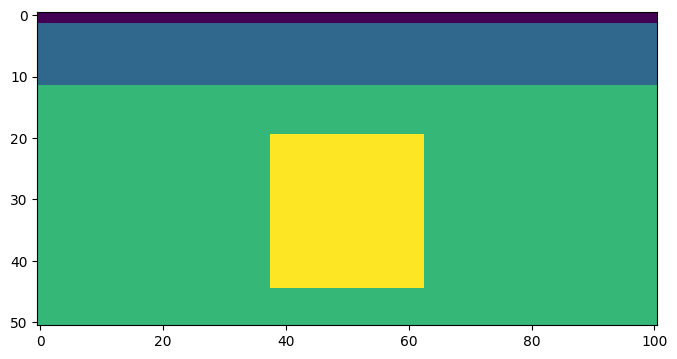

In [82]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

from google.colab import files
from matplotlib.figure import projections

plt.rcParams['figure.figsize'] = [8, 6]

# Carregar a matriz do arquivo
matriz = np.loadtxt('matriz.txt')

# Exibir a matriz
print("Matriz de tecidos:")
print(matriz)
plt.imshow(matriz)

2001


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


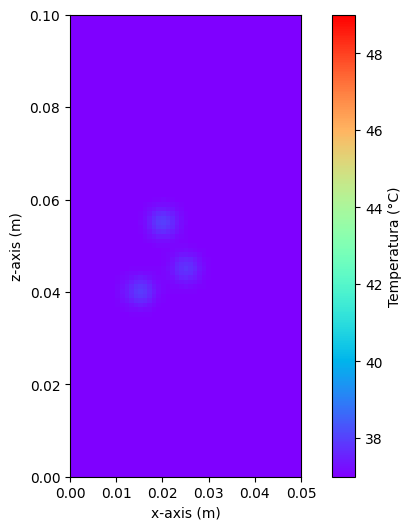

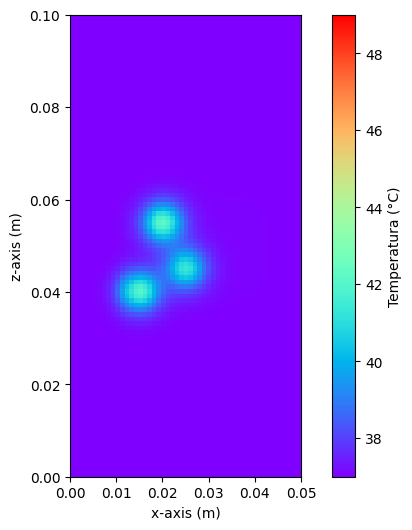

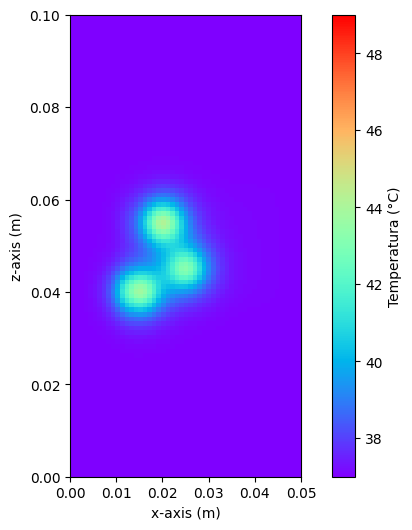

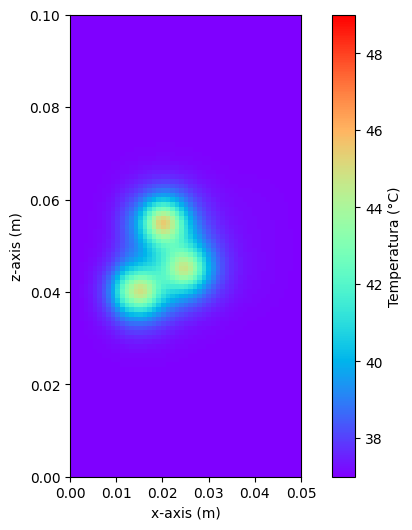

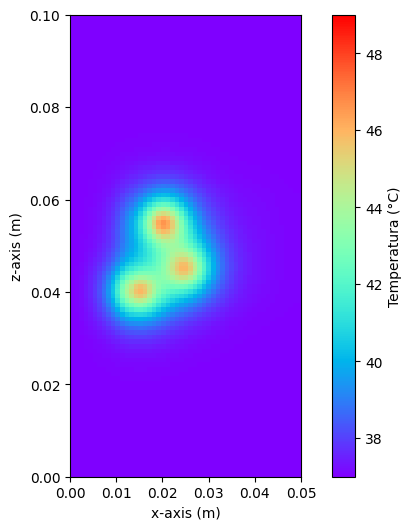

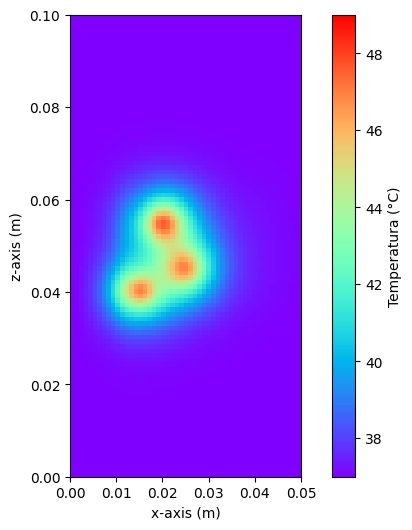

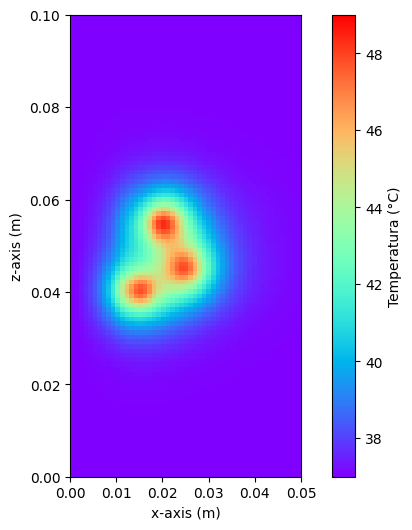

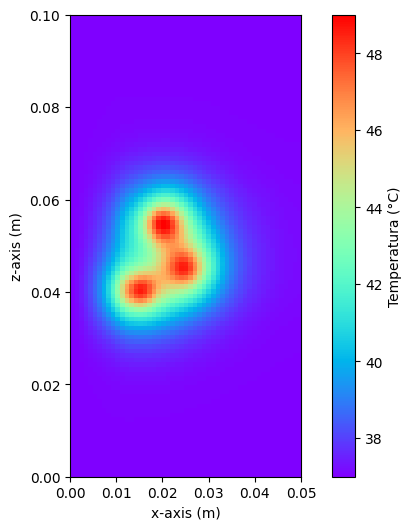

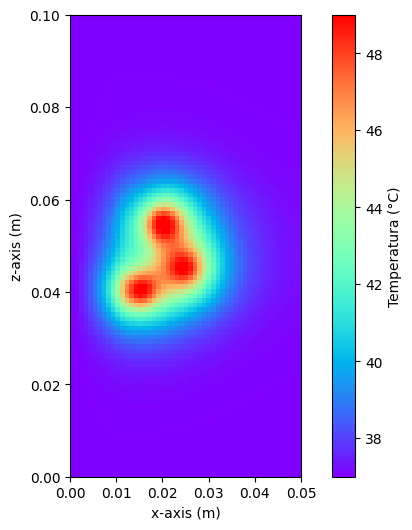

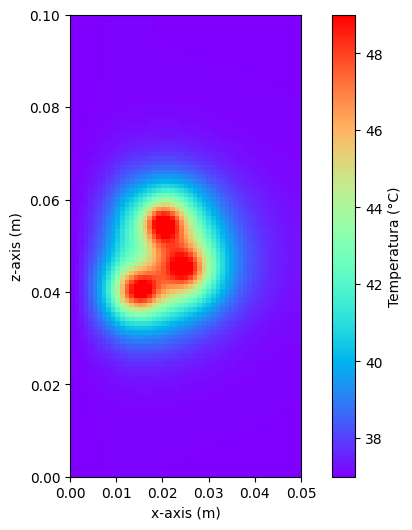

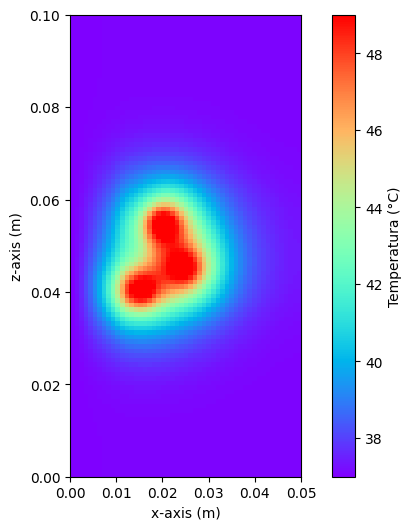

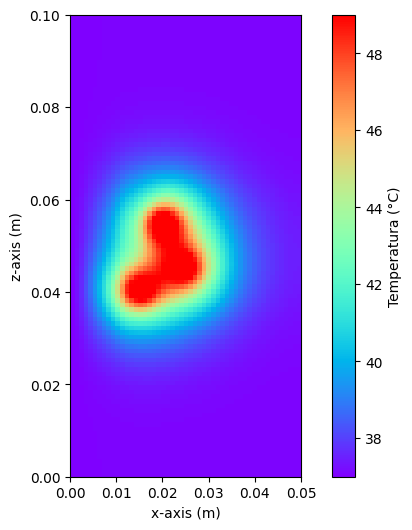

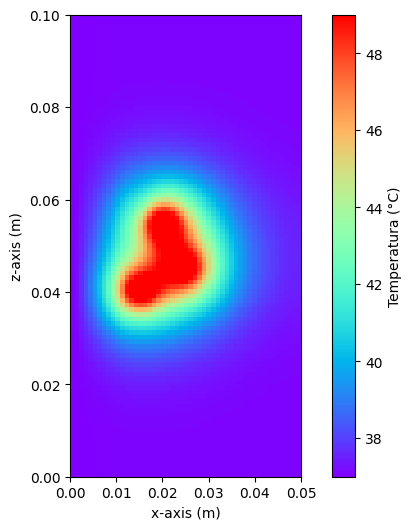

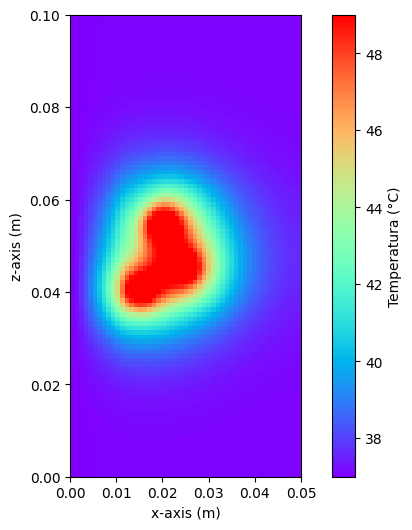

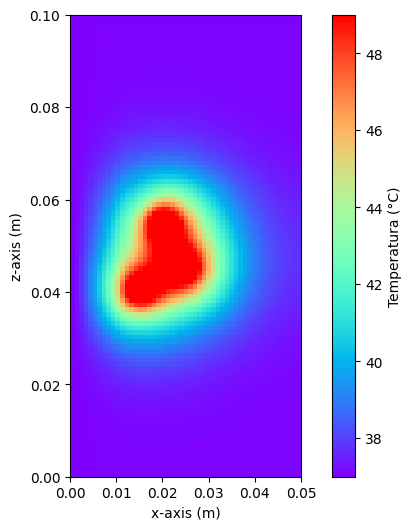

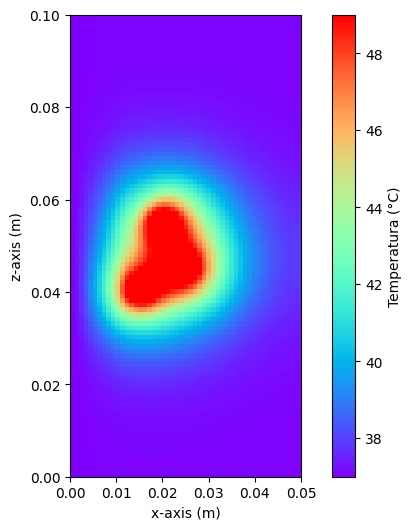

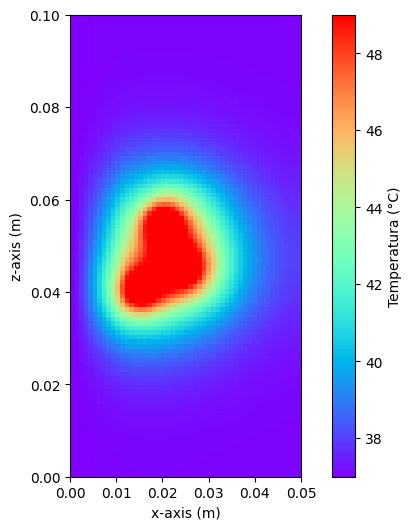

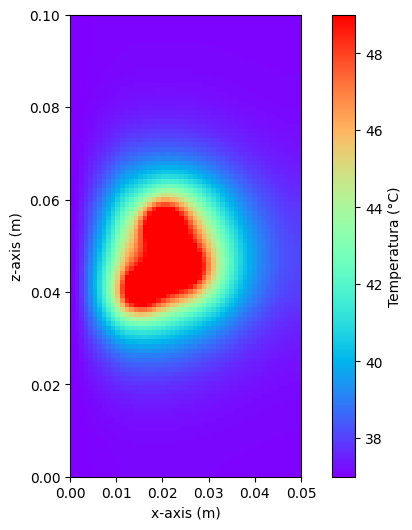

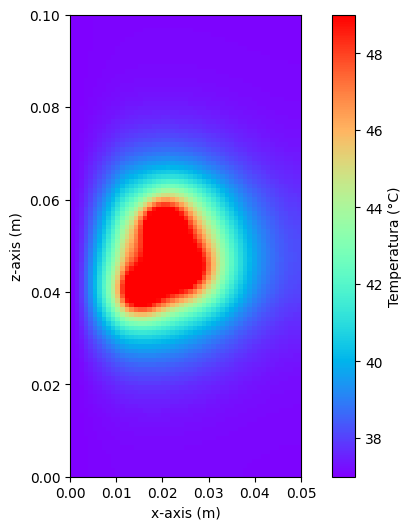

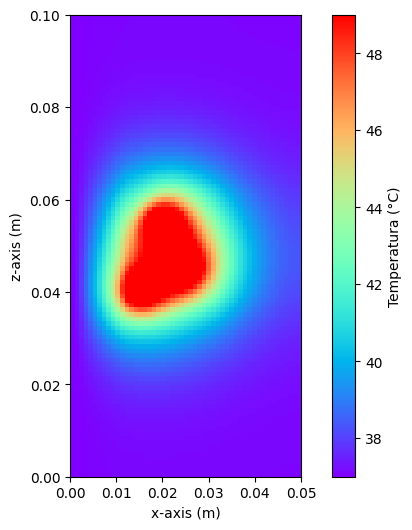

In [88]:
from tqdm import tqdm

# Carregar a matriz do arquivo
tamT = int(np.loadtxt('tamT.txt'))
print(tamT)

it=100

for k in tqdm(range(10,tamT, it)):
  #plt.plot(x,sol_tempo[k], label='t='+"{:.2f}".format(k*h_t))
  filename = f"final{k}.txt"
  sol_tempo = np.loadtxt(filename)

  fig = plt.figure()
  plt.xlabel('x-axis (m)')
  plt.ylabel('Temperatura (°C)')
  plt.ylabel('z-axis (m)')
  plt.imshow(np.transpose(sol_tempo), vmin = 37.0 , vmax = 49.0, cmap = 'rainbow', interpolation = 'nearest', origin = 'lower', extent=[0,0.05,0,0.1]) #u[len(x)-1][len(y)-1]
  plt.colorbar(label = 'Temperatura (°C)')

  grafics = "calor" + str(k) + ".png"
  plt.savefig(grafics, dpi=96)
plt.show()